# Brain Tumor Detection Using a Convolutional Neural Network

**About the Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

## Import Necessary Modules

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir



## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [3]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

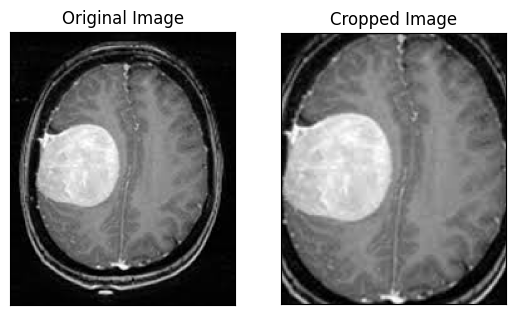

In [4]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [5]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [6]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [7]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

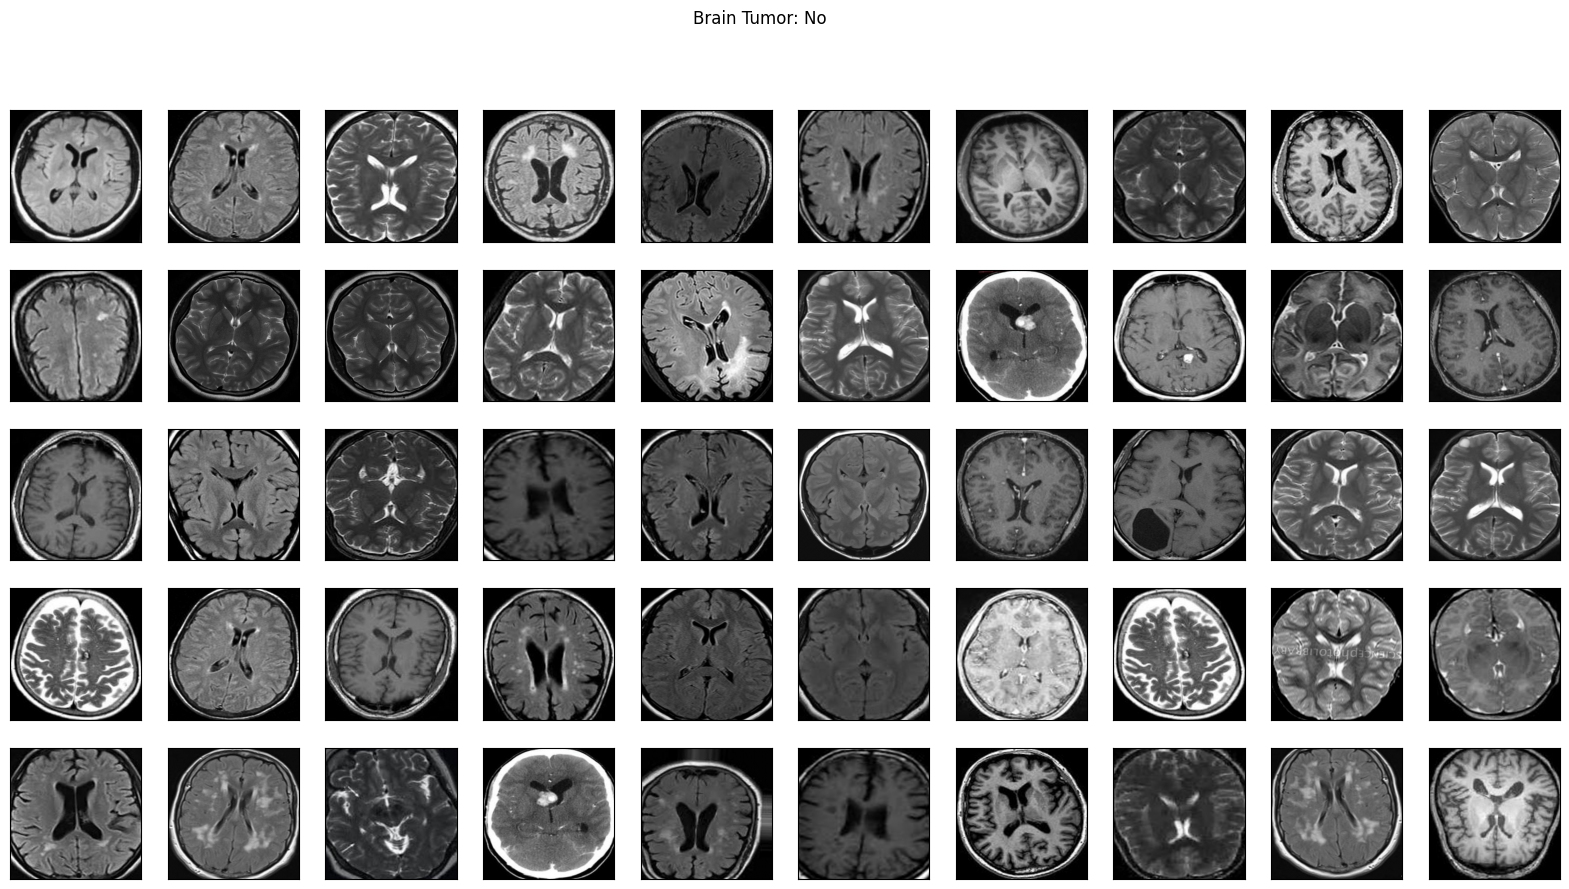

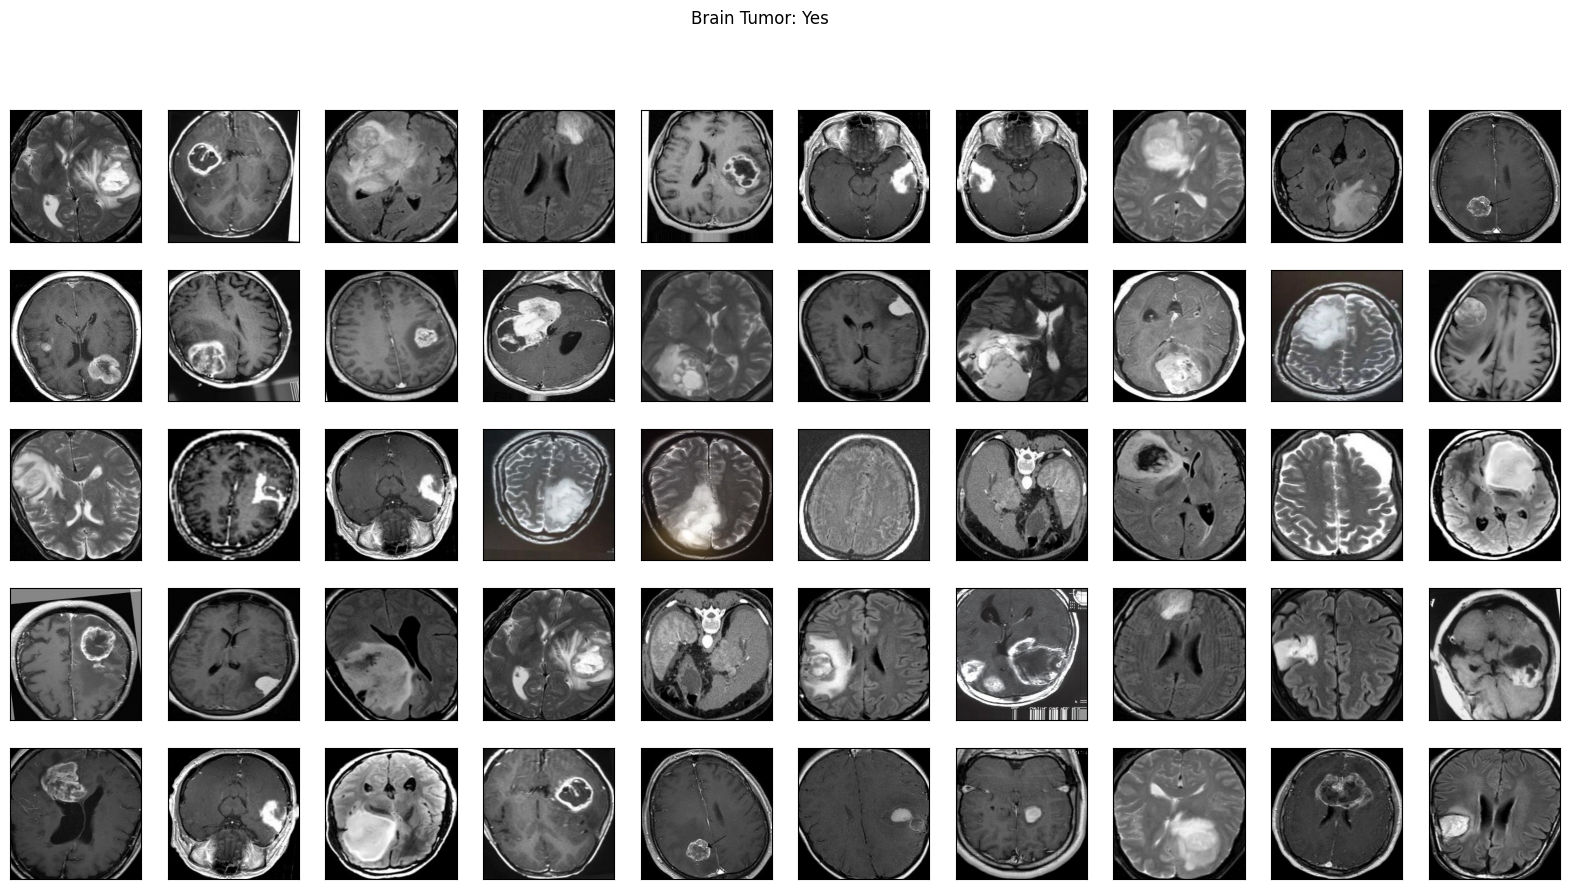

In [8]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [10]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [12]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


Some helper functions:

In [16]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [17]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

<img src='convnet_architecture.jpg'>

In [18]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [19]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [20]:
model = build_model(IMG_SHAPE)

In [21]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)      │      4,736 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)      │        128 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 6272)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ fc (Dense)                      │ (None, 1)                 │      6,273 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Compile the model:

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [24]:
filepath = "models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"
# Save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

## Train the model

In [25]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.5871 - loss: 0.9425
Epoch 1: val_accuracy improved from -inf to 0.60645, saving model to models/cnn-parameters-improvement-01-0.61.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 45s 847ms/step - accuracy: 0.5886 - loss: 0.9375 - val_accuracy: 0.6065 - val_loss: 0.6478
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.7861 - loss: 0.4519
Epoch 2: val_accuracy improved from 0.60645 to 0.66452, saving model to models/cnn-parameters-improvement-02-0.66.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 783ms/step - accuracy: 0.7861 - loss: 0.4522 - val_accuracy: 0.6645 - val_loss: 0.6163
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.7808 - loss: 0.4602
Epoch 3: val_accuracy improved from 0.66452 to 0.80645, saving model to models/cnn-parameters-improvement-03-0.81.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 803ms/step - accuracy: 0.7816 - loss: 0.4589 - val_accuracy: 0.8065 - val_loss: 0.5354
Epoch 4/10
46/46 ━━━━━━━━━━━━━━

Let's train for a few more epochs:

In [26]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.9154 - loss: 0.2017
Epoch 1: val_accuracy improved from 0.85806 to 0.87419, saving model to models/cnn-parameters-improvement-01-0.87.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 42s 845ms/step - accuracy: 0.9151 - loss: 0.2021 - val_accuracy: 0.8742 - val_loss: 0.3286
Epoch 2/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.9115 - loss: 0.2160
Epoch 2: val_accuracy did not improve from 0.87419
46/46 ━━━━━━━━━━━━━━━━━━━━ 37s 806ms/step - accuracy: 0.9116 - loss: 0.2156 - val_accuracy: 0.7419 - val_loss: 0.6374
Epoch 3/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.9483 - loss: 0.1619
Epoch 3: val_accuracy did not improve from 0.87419
46/46 ━━━━━━━━━━━━━━━━━━━━ 36s 782ms/step - accuracy: 0.9482 - loss: 0.1619 - val_accuracy: 0.8516 - val_loss: 0.3816
Elapsed time: 0:2:7.7


In [27]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.9500 - loss: 0.1378
Epoch 1: val_accuracy did not improve from 0.87419
46/46 ━━━━━━━━━━━━━━━━━━━━ 43s 857ms/step - accuracy: 0.9497 - loss: 0.1384 - val_accuracy: 0.8516 - val_loss: 0.3692
Epoch 2/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.9563 - loss: 0.1367
Epoch 2: val_accuracy did not improve from 0.87419
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 818ms/step - accuracy: 0.9560 - loss: 0.1371 - val_accuracy: 0.7516 - val_loss: 0.6227
Epoch 3/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.9434 - loss: 0.1539
Epoch 3: val_accuracy improved from 0.87419 to 0.88065, saving model to models/cnn-parameters-improvement-03-0.88.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 818ms/step - accuracy: 0.9433 - loss: 0.1542 - val_accuracy: 0.8806 - val_loss: 0.3411
Elapsed time: 0:2:7.8


In [28]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.8792 - loss: 0.2850
Epoch 1: val_accuracy did not improve from 0.88065
46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 917ms/step - accuracy: 0.8800 - loss: 0.2833 - val_accuracy: 0.8742 - val_loss: 0.3487
Epoch 2/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.9607 - loss: 0.1213
Epoch 2: val_accuracy did not improve from 0.88065
46/46 ━━━━━━━━━━━━━━━━━━━━ 39s 854ms/step - accuracy: 0.9607 - loss: 0.1213 - val_accuracy: 0.7968 - val_loss: 0.5668
Epoch 3/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.9692 - loss: 0.0926
Epoch 3: val_accuracy did not improve from 0.88065
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 860ms/step - accuracy: 0.9692 - loss: 0.0927 - val_accuracy: 0.8774 - val_loss: 0.3212
Elapsed time: 0:2:19.2


In [29]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.9665 - loss: 0.1069
Epoch 1: val_accuracy did not improve from 0.88065
46/46 ━━━━━━━━━━━━━━━━━━━━ 49s 979ms/step - accuracy: 0.9665 - loss: 0.1068 - val_accuracy: 0.7548 - val_loss: 0.6300
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 970ms/step - accuracy: 0.9666 - loss: 0.1006
Epoch 2: val_accuracy did not improve from 0.88065
46/46 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9665 - loss: 0.1009 - val_accuracy: 0.8419 - val_loss: 0.4375
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.9002 - loss: 0.2089
Epoch 3: val_accuracy did not improve from 0.88065
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 867ms/step - accuracy: 0.9006 - loss: 0.2082 - val_accuracy: 0.8645 - val_loss: 0.3920
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.9672 - loss: 0.1024
Epoch 4: val_accuracy did not improve from 0.88065
46/46 ━━━━━━━━━━━━━━━━━━━━ 38s 830ms/step - accuracy: 0.9672 - loss: 0.1023 - val_accuracy: 0.8645 - val_

In [30]:
history = model.history.history

In [31]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

In [69]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

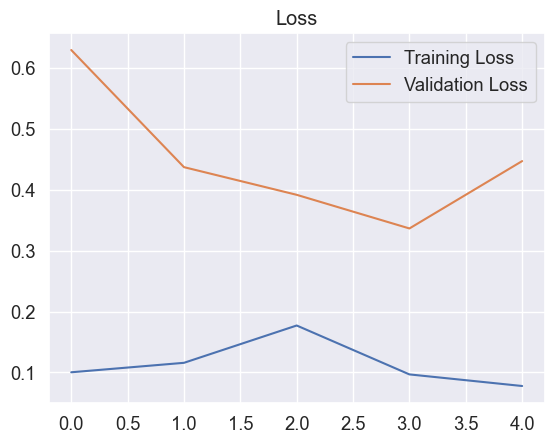

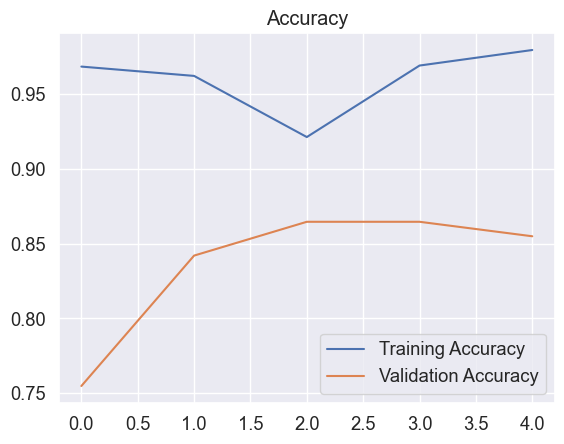

In [70]:
plot_metrics(history) 

ROC curve

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step


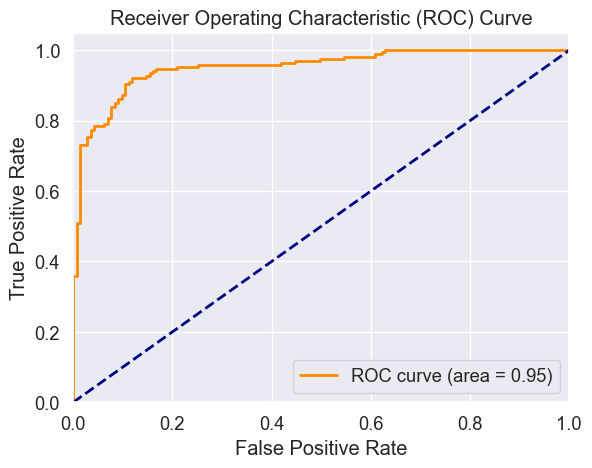

In [71]:
from sklearn.metrics import roc_curve, auc

# Assuming you have your test data in X_test and true labels in y_test

# Make predictions on the test set
y_pred_probs = model.predict(X_test)

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


confusion matrix

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step


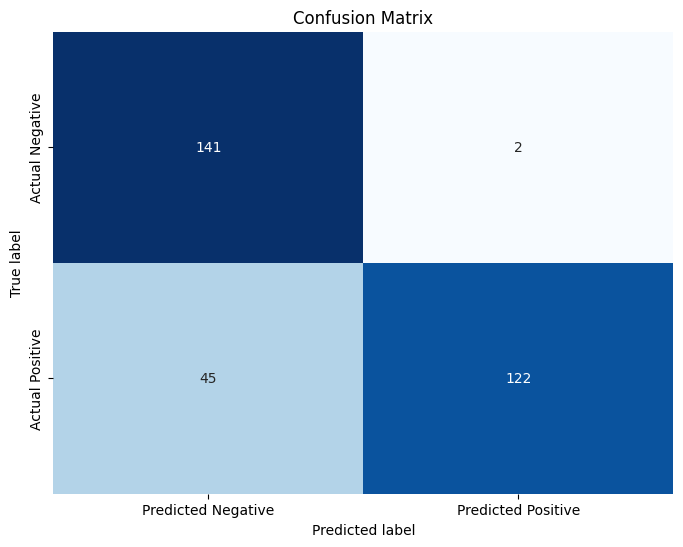

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs = model.predict(X_test)

# Threshold predicted probabilities to obtain binary predictions
y_pred_binary = (y_pred_probs > 0.5).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


Precision recall curve

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


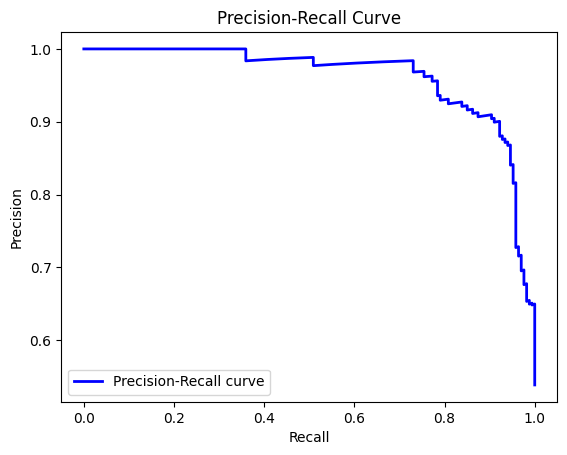

In [38]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Assuming you have your test data in X_test and true labels in y_test
# Assuming you have your trained model stored in 'model'

# Make predictions on the test set
y_pred_probs = model.predict(X_test)

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)

# Plot Precision-Recall curve
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


# Results

Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 23rd iteration with validation accuracy of 91%

### Load the best model

In [40]:
best_model = load_model(filepath='models/cnn-parameters-improvement-10-0.88.keras')

In [41]:
best_model.metrics_names

['loss', 'compile_metrics']

Evaluate the best model on the testing data:

In [42]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9137 - loss: 0.2447


### Accuracy of the best model on the testing data:

In [43]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.24796059727668762
Test Accuracy = 0.9161290526390076


### F1 score for the best model on the testing data:

In [44]:
y_test_prob = best_model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


In [45]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9207317073170732


Let's also find the f1 score on the validation data:

In [46]:
y_val_prob = best_model.predict(X_val)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


In [47]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9022082018927445


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [48]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [49]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [50]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.11072664359862%, number of pos examples: 753
Percentage of negative examples: 47.88927335640138%, number of neg examples: 692
Validation Data:
Number of examples: 310
Percentage of positive examples: 53.225806451612904%, number of pos examples: 165
Percentage of negative examples: 46.774193548387096%, number of neg examples: 145
Testing Data:
Number of examples: 310
Percentage of positive examples: 53.87096774193548%, number of pos examples: 167
Percentage of negative examples: 46.12903225806452%, number of neg examples: 143


As expectred, the percentage of positive examples are around 50%.

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

y_pred = y_pred_binary

# Classification Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_test_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the computed metrics and values
print("Classification Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Confusion Matrix:\n{conf_matrix}")


Classification Metrics:
Accuracy: 0.8483870967741935
Precision: 0.9838709677419355
Recall: 0.7305389221556886
F1-score: 0.8384879725085911
ROC AUC: 0.972321092081571
Confusion Matrix:
[[141   2]
 [ 45 122]]


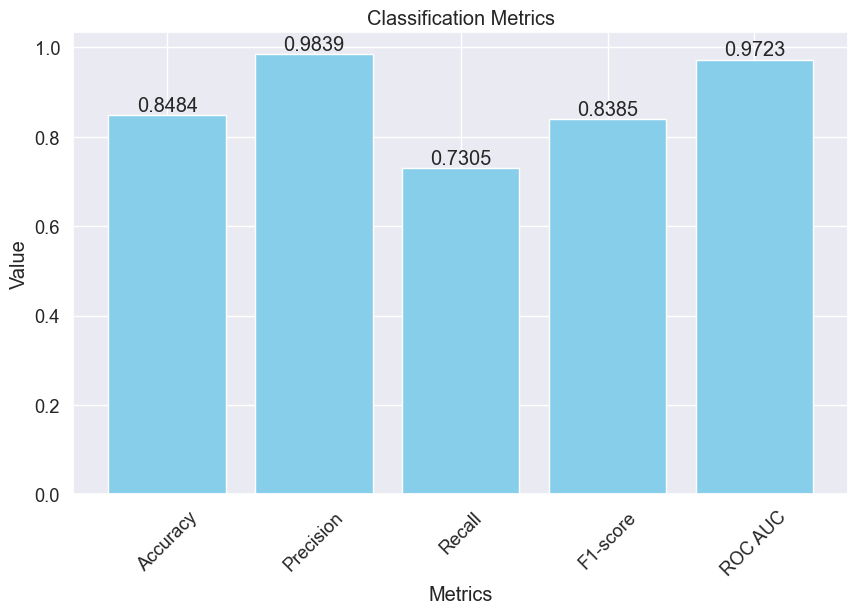

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming you have your true labels in y_test, predicted labels in y_pred_binary, and predicted probabilities in y_test_prob

# Compute classification metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_test_prob)

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "F1-score", "ROC AUC"],
    "Value": [accuracy, precision, recall, f1, roc_auc]
})

# Plot bar chart with annotations
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_df["Metric"], metrics_df["Value"], color='skyblue')
plt.xlabel('Metrics')
plt.ylabel('Value')
plt.title('Classification Metrics')
plt.xticks(rotation=45)

# Add annotations
for bar, value in zip(bars, metrics_df["Value"]):
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             round(value, 4), 
             ha='center', 
             va='bottom')

plt.show()


# Conclusion:

#### Now, the model detects brain tumor with:<br>
**88.7%** accuracy on the **test set**.<br>
**0.88** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 91%            | 89%      |
| F1 score  | 0.91           | 0.88     |

Hooray!

In [40]:
path="./no/1 no.jpeg"
image = cv2.imread(path)
image=crop_brain_contour(image,False)
image = cv2.resize(image, dsize=(240,240), interpolation=cv2.INTER_CUBIC)
image = image / 255.
image.shape


(240, 240, 3)